## 1) Preprocess all the necessary variables
### 1.1) Build feature, target and initial normalization files

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import limit_mem
import tensorflow as tf
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

Using TensorFlow backend.
/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [3]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
import xarray as xr
ds = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc', 
                     decode_times=False)
ds.PS.mean(dim=['time','lon','lat'])

<xarray.DataArray 'PS' ()>
array(98098.07, dtype=float32)

In [4]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_ref_tbeucler_local.yml \
--aqua_names '*.h1.0000-*-01-*' \
--out_pref 32_col_mp_3d_train

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 2.07 s
Number of time steps: 576
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Time checkpoint create datasets: 2.15 s
Time checkpoint reshape and rechunk: 6.38 s
Compute means and stds
Saving normalization file: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_norm.nc
Time checkpoint normalization arrays: 86.04 s
Time checkpoint rechunk and ds: 86.64 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_targets.nc
Total time: 122.43 s


In [7]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'

In [24]:
!ls $TRAINDIR
%cd $TRAINDIR
!pwd
#!rm 32_col*

32_col_mp_3d_train_features.nc	32_col_mp_3d_train_shuffle_features.nc
32_col_mp_3d_train_norm.nc	32_col_mp_3d_train_shuffle_targets.nc
32_col_mp_3d_train_oldnorm.nc	32_col_mp_3d_train_targets.nc
/data/Tom.Beucler/SPCAM_PHYS
/data/Tom.Beucler/SPCAM_PHYS


### 1.2) Shuffle the data
tgb - 1/16/2019 - Adapted from Stephan's entire worlflow for 32 column run

In [7]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/shuffle_ds.py -h

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
usage: shuffle_ds.py [-h] [--method METHOD] [--pref PREF]
                     [--random_seed RANDOM_SEED] [--chunk_size CHUNK_SIZE]
                     [--verbose VERBOSE]

optional arguments:
  -h, --help            show this help message and exit
  --method METHOD       [Meticulous or fast]
  --pref PREF           Prefix. ie without the _features.nc
  --random_seed RANDOM_SEED
                        Random seed for shuffling of data.
  --chunk_size CHUNK_SIZE
                        Size of chunks for fast method
  --verbose VERBOSE     Verbosity level


In [8]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_mp_3d_train

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]


### 1.3) Change the output's normalization using pressure levels
#### Step 0: Load the file using xarray

In [9]:
import xarray as xr
ds.close()
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')

In [10]:
ds.target_conv


<xarray.DataArray 'target_conv' (target_lev: 125)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

#### Step 1: Check already existing normalizations
$$
\left(\frac{dq_{v,l,i}}{dt}\right)\rightarrow\frac{L_{v}}{g}\ \left(\mathrm{Missing}\ \Delta p\right)
$$
$$
\left(\frac{dT}{dt}\right)\rightarrow\frac{c_{p}}{g}\ \left(\mathrm{Missing\ }\Delta p\right)
$$
$$
{\cal F}_{\mathrm{rad}}\rightarrow1\ \left(\mathrm{All\ good}\right)
$$
$$
\mathrm{Precip}_{{\cal V}}\rightarrow\rho L_{v}\ \left(\mathrm{All\ good}\right)
$$
We need to multiply the first (4 variables) * (30 levels) by the vector delta_p (level)


#### Step 2: Calculate differential pressure for each level

In [11]:
# 1.1 Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 1.2 Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]
dP

array([ 277.64523402,  512.62555644,  839.73696455, 1211.38058603,
       1519.8353678 , 1745.60062587, 1737.79353499, 1423.96241426,
       1675.21685362, 1970.80597281, 2318.55362654, 2727.6545763 ,
       3208.94680917, 3775.1596421 , 4441.27991796, 5224.93720055,
       6146.86310291, 7231.4709425 , 8507.44917989, 8510.85484028,
       7811.29226089, 6591.71789885, 4899.05960858, 2836.21996641,
       2660.87651253, 2463.98309246, 2246.78721279, 2010.62900014,
       1757.35657103, 1488.78097534])

#### Step 3: Multiply Q/T tendency components of the norm. vector by dp

In [12]:
import numpy as np

ds.target_conv[:120] = np.multiply(ds.target_conv[:120],np.concatenate((dP,dP,dP,dP)))

In [13]:
ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 125)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

#### Step 4: Replace targ_conv in the train_norm NETCDF file with the new values

In [14]:
# 4.1 Copy old normalization file
path1 = os.path.join(TRAINDIR,'32_col_mp_3d_train_norm.nc')
path2 = os.path.join(TRAINDIR,'32_col_mp_3d_train_oldnorm.nc')
!cp $path1 $path2

In [15]:
# 4.1.CHECK that the old normalization file was properly copied
xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_oldnorm.nc').target_conv

<xarray.DataArray 'target_conv' (target_lev: 125)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

In [16]:
# 4.2 Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })

In [17]:
# 4.2 Check
new_ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 125)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

In [18]:
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file

In [19]:
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

In [20]:
# 4.3 CHECK
xr.open_dataset(path1).close() # Don't forget to close the old handler!!
xr.open_dataset(path1).target_conv # Before checking if the new normalizations are at the right place

<xarray.DataArray 'target_conv' (target_lev: 125)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

## 2) Create data generator and produce data sample


### 2.1) Create data generator

In [ ]:
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

In [8]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn='32_col_mp_3d_train_features.nc',
    target_fn='32_col_mp_3d_train_targets.nc',
    batch_size=512,
    norm_fn='32_col_mp_3d_train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 4620288 samples in 9024 batches
Features have shape 154; targets have shape 125


In [9]:
gen = train_gen_obj.return_generator()

### 2.2) Produce data sample

In [10]:
x, y = next(gen)

In [11]:
x.shape, y.shape

((512, 154), (512, 125))

## 3) Simple neural network

In [12]:
from keras.layers import *
from keras.models import *

### 3.1) A simple example

In [13]:
inp = Input(shape=(154,))
act = Dense(124, activation='relu')(inp)
for i in range (7):
    act = Dense(124, activation='relu')(act)
out = Dense(125)(act)
model1 = Model(inputs=inp, outputs=out)

In [14]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 154)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 124)               19220     
_________________________________________________________________
dense_11 (Dense)             (None, 124)               15500     
_________________________________________________________________
dense_12 (Dense)             (None, 124)               15500     
_________________________________________________________________
dense_13 (Dense)             (None, 124)               15500     
_________________________________________________________________
dense_14 (Dense)             (None, 124)               15500     
_________________________________________________________________
dense_15 (Dense)             (None, 124)               15500     
__________

In [15]:
model1.compile('adam', loss='mse')

In [16]:
model1.fit_generator(gen, train_gen_obj.n_batches, epochs=2)

Epoch 1/2
9024/9024 [==============================] - 64s 7ms/step - loss: 295.4242
Epoch 2/2
9024/9024 [==============================] - 56s 6ms/step - loss: 210.5696


In [17]:
preds = model1.predict_on_batch(x)

In [18]:
preds.shape

(512, 125)

array([ 0.0000000e+00,  0.0000000e+00,  1.1683633e-04, -1.8150534e-04,
        2.8191236e-05, -1.2674624e-04,  3.2557498e-04, -2.3665362e-04,
        1.0368231e-04,  4.4764183e-04,  9.7565079e-04,  6.6266386e-03,
       -2.4458408e-02,  7.7702858e-02, -7.9534091e-02, -3.0769283e-01,
       -2.9614696e-01, -3.2436770e-01, -1.4933038e+01,  1.1325694e+02,
        1.1042747e+02, -1.3367409e+02, -9.7812202e+01, -1.2961019e+01,
       -2.1165226e+01, -3.0767555e+01, -1.5683941e+01,  6.6389933e+00,
       -3.9723598e+01, -5.9443699e+01,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  2.3594544e+00,  6.4320625e+01, -2.1832945e+01,
       -4.4953237e+00,  2.9705560e+00, -4.5950494e+00, -4.7523217e+00,
      

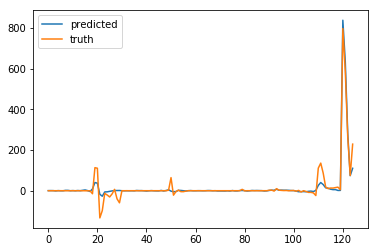

In [19]:
plt.plot(preds[413])
plt.plot(y[413])
plt.legend(['predicted','truth'])
y[413,]
#plt.axis([0,50,-50,20])

### 3.2) Implement energy conservation layer
#### Step 0: Load input's normalization separately

In [13]:
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')
ds

<xarray.Dataset>
Dimensions:              (feature_lev: 154, target_lev: 125)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 ... 149 150 151 152 153
  * target_lev           (target_lev) int64 0 1 2 3 4 5 ... 120 121 122 123 124
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...

In [14]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print(fsub.shape)
print(fdiv.shape)
print(normq.shape)

(154,)
(154,)
(125,)


In [15]:
ds.close()

#### Step 1: Test the physical constraint layer in Numpy for basic debugging

In [24]:
import numpy as np
def safe_softplus(x, limit=30):
  if x>limit:
    return x
  else:
    return np.log(1.0 + np.exp(x))

In [25]:
print(qap.shape)
print(fsub.shape)

NameError: name 'qap' is not defined

In [100]:
x, y = next(gen) # (Input,Output) pair retrieved iteratively from the generator
testinp = x; testdensout = y;  # The output of the densely connected layer,
# which is the input for the physical constraints layer, has shape (125,)=y.shape
qbp = np.add(np.multiply(testinp[:,:90],fdiv[:90,]),fsub[:90,])
index = 5
print(qbp[index,:])
# Bound on dq/dt
np.multiply(normq[:90,],qbp[index,:])/1800

[1.8890089e-06 1.8709759e-06 1.7035223e-06 1.7005252e-06 1.6415983e-06
 1.5045957e-06 1.4606607e-06 1.4591218e-06 1.4598600e-06 1.4735780e-06
 1.5066166e-06 1.5988817e-06 2.0526277e-06 4.9225710e-06 1.0806412e-05
 2.0793159e-05 5.1943964e-05 1.3326522e-04 2.4402043e-04 3.3523864e-04
 6.6088326e-04 1.1144076e-03 1.5189773e-03 1.8160637e-03 2.0421566e-03
 2.2358480e-03 2.4027592e-03 2.5413563e-03 2.7411170e-03 2.9877913e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7347235e-18 0.0000000e+00 0.0000000e+00 2.2737368e-13 0.0000000e+00
 0.0000000e+00 9.0949470e-13 9.5405994e-09 4.6377809e-06 1.5204386e-05
 1.5759480e-05 4.7640169e-06 1.4436255e-06 1.9511208e-07 5.5640478e-05
 1.2481135e-09 1.0923745e-09 6.6391337e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

array([7.4313283e-02, 1.3589725e-01, 2.0269047e-01, 2.9188102e-01,
       3.5351321e-01, 3.7214047e-01, 3.5965800e-01, 2.9439625e-01,
       3.4651691e-01, 4.1148993e-01, 4.9495089e-01, 6.1794227e-01,
       9.3328631e-01, 2.6331131e+00, 6.8003597e+00, 1.5393726e+01,
       4.5240860e+01, 1.3654811e+02, 2.9414923e+02, 4.0426810e+02,
       7.3145874e+02, 1.0408422e+03, 1.0544020e+03, 7.2981561e+02,
       7.6993835e+02, 7.8058862e+02, 7.6491705e+02, 7.2400189e+02,
       6.8254248e+02, 6.3026514e+02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.2842618e-12, 0.0000000e+00, 0.0000000e+00,
       2.7408277e-07, 0.0000000e+00, 0.0000000e+00, 8.4945623e-07,
       6.6226311e-03, 1.8637701e+00, 5.7323909e+00, 5.5020161e+00,
       1.5166223e+00, 4.1127157e-01, 4.8583217e-02, 1.1737184e

In [109]:
# SOFTPLUS
import copy
qap = copy.copy(testdensout[:,:90])
print(qap)
print(qap[5,:])
for i in range(qap.shape[0]):
    for j in range (qap.shape[1]):
        qap[i,j] = safe_softplus(qap[i,j])
print(qap,qap.shape)          


[[ 0.00000000e+00  0.00000000e+00 -3.52463167e-06 ...  7.14828730e-01
  -1.94745120e-02 -5.09016812e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.91810636e-06 ... -8.12336057e-02
   1.09404393e-01 -2.64686853e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.83413817e-06 ...  2.25569099e-01
  -5.04336655e-02 -1.75489992e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00 -4.57383749e-06 ...  4.15254906e-02
   3.08697671e-01 -1.18188016e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.56462510e-06 ...  8.04110393e-02
  -4.38176608e-03  3.40724625e-02]
 [ 0.00000000e+00  0.00000000e+00 -5.02103740e-06 ... -5.38274534e-02
  -2.09472924e-01 -1.75753996e-01]]
[ 0.0000000e+00  0.0000000e+00 -3.1418069e-06 -3.6398256e-07
  3.0054719e-06 -1.6221151e-05  8.7531935e-06  1.2292489e-05
  1.0967176e-05 -6.3576708e-06  3.7818052e-07 -2.8339788e-04
 -1.0227459e-03 -2.1273026e-03 -3.6572393e-02  2.8603417e-03
 -2.7998945e-01 -4.5961341e-01  9.0005070e-01  6.8134266e-01
 -8.2287771e-01  2.3013981e-01  2.4323208e+00 -8.4881544e-0

#### Step 2: Rigorously implement the physical constraint layer in tensorflow

In [143]:
class PositiveConstraintLayer(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, inp):
        # inputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # SOFTPLUS PART
        qap = inp[:, :90]
        remain = inp[:, 90:]
        # softplus on x_q
        qap = K.softplus(qap)
        
        # Concat out
        out = K.concatenate([qap, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [144]:
class CloudTendencyLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # Identify qap and rest of vector
        qap = densout[:, :90]
        remain = densout[:, 90:]
        
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [60]:
class PhysicalConstraintLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # SOFTPLUS PART
        qap = densout[:, :90]
        remain = densout[:, 90:]
        # softplus on x_q, then multiply by 10^-3 for order of magnitude
        qap = tf.math.multiply(1e-3,K.relu(qap))
        
        # FROM Q TO DQ/DT
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # OPTION 2
        # 1) Normalize qap
        #qap = tf.math.divide(tf.math.subtract(qap,self.fsub[:90,]),self.fdiv[:90,])
        # 2) Calculate temporal difference
        #qbp = inp[:, :90]
        #diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Unnormalize dq/dt
        #diff = tf.math.multiply(diff,self.fdiv[:90,])
        # 4) Normalize the temporal difference according to output's normalization
        #diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [61]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
out = PhysicalConstraintLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [146]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
densout = PositiveConstraintLayer(
    input_shape=(125,)
)(densout)
out = CloudTendencyLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [64]:
m.compile('adam', 'mse')

In [65]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 154)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 256)          39680       input_8[0][0]                    
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 256)          65792       dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 256)          65792       dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (

In [69]:
m.fit_generator(gen, train_gen_obj.n_batches, epochs=5)

Epoch 1/5
9024/9024 [==============================] - 33s 4ms/step - loss: 4074.8826
Epoch 2/5
9024/9024 [==============================] - 32s 4ms/step - loss: 3002.3257
Epoch 3/5
9024/9024 [==============================] - 32s 4ms/step - loss: 2749.5319
Epoch 4/5
9024/9024 [==============================] - 32s 4ms/step - loss: 2036.9388
Epoch 5/5
9024/9024 [==============================] - 34s 4ms/step - loss: 1755.3189


In [67]:
preds = m.predict_on_batch(x)

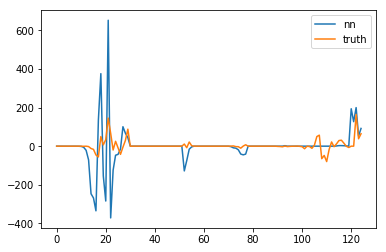

In [68]:
plt.plot(preds[510], label='nn')
plt.plot(y[510], label='truth')
plt.legend();
#plt.axis([0,50,-100,100])

TODO: Validation